In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import (PercentileInterval, LogStretch, PowerStretch, ManualInterval, ZScaleInterval, ImageNormalize)
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib.patches import Circle
import pandas as pd
import os

from astroquery.vizier import Vizier

from casatasks import listobs, clearcal, setjy, gaincal, bandpass, applycal, tclean, flagdata, ft, exportfits
from casatools import componentlist, msmetadata

In [ ]:
# Path to the measurement set
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-02-14/trial_022525'
msfile = '2025-02-14T13:07:27_ra224.0_dec+71.7.ms'
imagefile = msfile.split('.ms')[0] + '_clean.image'
fitsfile = imagefile + '.fits'
fitsfile = '2025-02-14T13:07:27_ra224.0_dec+71.7_drift_ra14h55m35s_clean.image.fits'

#if os.path.exists(os.path.join(basepath, fitsfile)) is None:
#exportfits(os.path.join(basepath, imagefile), os.path.join(basepath, fitsfile))

Total fields: 24
Geometric center: RA = 223.976653 deg, Dec = 71.741738 deg
Central field ID (closest to center): 11
Field Extent (Degrees):
  RA:  223.354016 to 224.599269 (Extent: 1.245253 degrees)
  Dec: 71.740709 to 71.742759 (Extent: 0.002050 degrees)

Including Primary Beam FWHM (2.946 degrees):
  RA:  221.881191 to 226.072094
  Dec: 70.267884 to 73.215584
Querying VIII/65/nvss ...


Set OBSGEO-B to    37.280380 from OBSGEO-[XYZ].
Set OBSGEO-H to     2193.256 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


              NVSS      RAJ2000      DEJ2000  e_RAJ2000  e_DEJ2000    S1.4  \
228  144840+701820  14 48 40.87  +70 18 20.3       0.09        0.6   300.0   
346  145907+714019  14 59 07.63  +71 40 19.9       0.10        0.6  7468.4   
480  151012+704644  15 10 12.98  +70 46 44.1       0.09        0.6   407.8   
482  151024+704532  15 10 24.06  +70 45 32.7       0.09        0.6  1066.8   
586  151937+713658  15 19 37.33  +71 36 58.2       0.10        0.6   312.8   
599  152047+722504  15 20 47.46  +72 25 04.8       0.10        0.6  1549.1   

         e_S1.4 l_MajAxis    MajAxis l_MinAxis    MinAxis f_resFlux  
228    9.000000         <  19.100000         <  17.600000            
346  224.100006         <  17.900000         <  16.600000            
480   13.500000            50.700001            43.500000        P*  
482   33.900002            71.599998            50.200001        P*  
586    9.400000         <  19.700001         <  15.600000        P*  
599   52.900002            25.100

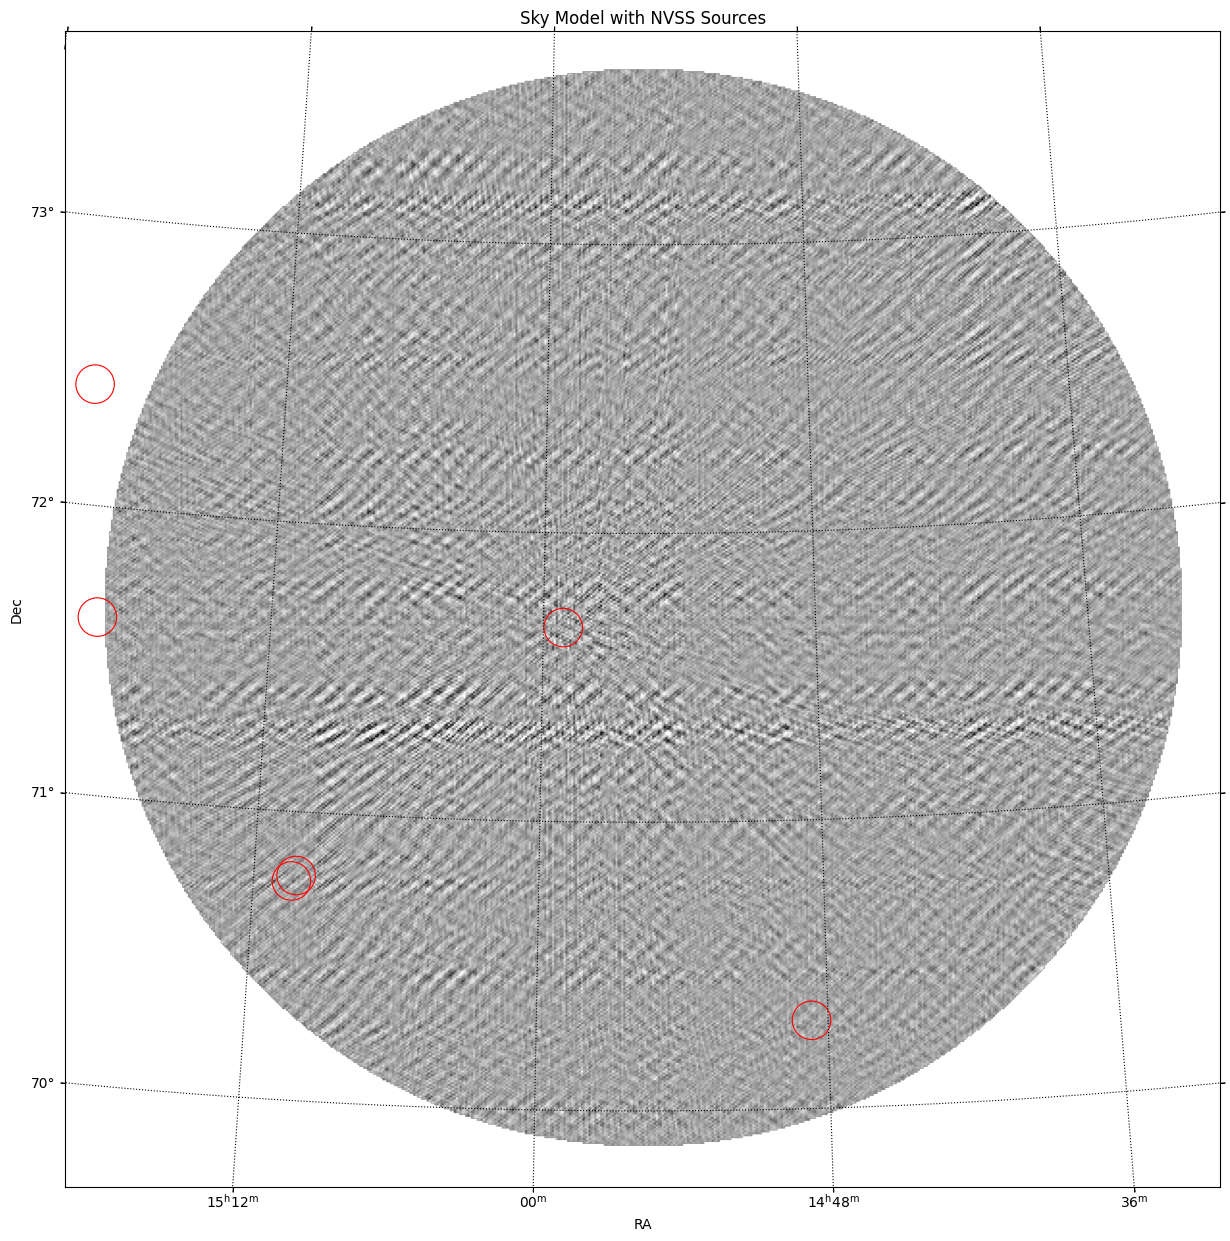

In [12]:
# Open the measurement set
msmd = msmetadata()
msmd.open(os.path.join(basepath, msfile))

# Get the total number of fields
num_fields = msmd.nfields()

# Retrieve phase centers for all fields
phase_centers = []
for field_id in range(num_fields):
    pc = msmd.phasecenter(field_id)
    ra = pc['m0']['value']  # RA in radians
    dec = pc['m1']['value']  # Dec in radians
    phase_centers.append((ra, dec))

# Convert to degrees for easier interpretation
rad2deg = lambda x: ((x * 180.0 / np.pi) + 360) % 360 
phase_centers_deg = [(rad2deg(ra), rad2deg(dec)) for ra, dec in phase_centers]

# Calculate the geometric mean center (central coordinate)
center_ra = np.mean([coord[0] for coord in phase_centers_deg])
center_dec = np.mean([coord[1] for coord in phase_centers_deg])

# Find the closest field to the geometric center
center_coord = SkyCoord(center_ra, center_dec, unit='deg')
field_coords = SkyCoord([coord[0] for coord in phase_centers_deg],
                        [coord[1] for coord in phase_centers_deg],
                        unit='deg')
separations = center_coord.separation(field_coords)

# Get the field ID closest to the central coordinate
center_field_id = np.argmin(separations.arcsec)

print(f"Total fields: {num_fields}")
print(f"Geometric center: RA = {center_ra:.6f} deg, Dec = {center_dec:.6f} deg")
print(f"Central field ID (closest to center): {center_field_id}")

ra_values = [coord[0] for coord in phase_centers_deg]
dec_values = [coord[1] for coord in phase_centers_deg]
min_ra, max_ra = min(ra_values), max(ra_values)
min_dec, max_dec = min(dec_values), max(dec_values)

# Calculate angular extent
ra_extent = max_ra - min_ra
dec_extent = max_dec - min_dec

# Add primary beam size (optional)
# Assume observing frequency = 1.4 GHz and dish diameter = 25 m (VLA example)
frequency_hz = 1.28e9  # Hz
dish_diameter_m = 4.65  # meters
primary_beam_fwhm_deg = (1.02 * (3e8 / frequency_hz) / dish_diameter_m) * (180 / np.pi)

# Adjust RA and Dec bounds by primary beam size
min_ra_adjusted = min_ra - primary_beam_fwhm_deg / 2
max_ra_adjusted = max_ra + primary_beam_fwhm_deg / 2
min_dec_adjusted = min_dec - primary_beam_fwhm_deg / 2
max_dec_adjusted = max_dec + primary_beam_fwhm_deg / 2

print(f"Field Extent (Degrees):")
print(f"  RA:  {min_ra:.6f} to {max_ra:.6f} (Extent: {ra_extent:.6f} degrees)")
print(f"  Dec: {min_dec:.6f} to {max_dec:.6f} (Extent: {dec_extent:.6f} degrees)")

print(f"\nIncluding Primary Beam FWHM ({primary_beam_fwhm_deg:.3f} degrees):")
print(f"  RA:  {min_ra_adjusted:.6f} to {max_ra_adjusted:.6f}")
print(f"  Dec: {min_dec_adjusted:.6f} to {max_dec_adjusted:.6f}")

# Close the msmd tool
msmd.done()

ra_deg = center_ra
dec_deg = center_dec

#search_radius =  60 # arcminutes
search_width = max_ra_adjusted - min_ra_adjusted # degrees
search_height = max_dec_adjusted - min_dec_adjusted # degrees
nvss_flux_col = "S1.4"  # NVSS flux column
nvss_cat_code = "VIII/65/nvss"  # NVSS catalog
top_n = 10  # Number of sources to include in the component list

# Function to calculate spectral index
def calculate_spectral_index(flux_nvss, freq_nvss, flux_tgss, freq_tgss):
    return np.log(flux_nvss / flux_tgss) / np.log(freq_nvss / freq_tgss)

# Query the NVSS catalog
print(f"Querying {nvss_cat_code} ...")
target_coord = SkyCoord(ra_deg, dec_deg, unit='deg')
Vizier.ROW_LIMIT = -1  # no row limit
Vizier.columns = ["*"]  # retrieve all columns

nvss_result = Vizier.query_region(
    target_coord,
    #adius=f"{search_radius}m",
    width=f"{search_width}d",
    height=f"{search_height}d",
    catalog=nvss_cat_code,
    frame='icrs'
)

nvss_catalog = nvss_result[0].to_pandas()

# Step 1: Load the FITS image
#fits_file = "/data/jfaber/nsfrb_cand/msdir/2025_01_30T03h_15m_45m_avg/nvss_top10_063p212_69p005.cl_field_clean.image.fits"  # Replace with your FITS file
fits_file = os.path.join(basepath, fitsfile)
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Step 2: Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (15, 15))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Step 3: Load the NVSS catalog
# Example NVSS catalog as a CSV (replace with your actual catalog)
catalog = nvss_catalog #pd.read_csv("nvss_catalog.csv")
catalog = catalog[catalog['S1.4'] > 200]  # Filter sources brighter than 500 mJy

print(catalog)

# Step 4: Convert NVSS RA/Dec to pixel coordinates
nvss_coords = SkyCoord(ra=catalog['RAJ2000'], dec=catalog['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

# Extract RA, Dec, and add constant frequency and Stokes
ra_deg = nvss_coords.ra.deg
dec_deg = nvss_coords.dec.deg
freq_array = [freq_val] * len(ra_deg)  # Repeat frequency for all sources
stokes_array = [stokes_val] * len(ra_deg)  # Repeat Stokes for all sources

# Pass all 4 axes to wcs.world_to_pixel
x, y = wcs_2d.world_to_pixel_values(ra_deg, dec_deg)
#
## Step 5: Overlay circles on the FITS image
for xi, yi in zip(x, y):
    circle = Circle((xi, yi), radius=10, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)
#
## Step 6: Show the plot
plt.title('Sky Model with NVSS Sources')
plt.grid(color='k', ls='dotted')
plt.show()


In [4]:
# Path to the measurement set
basepath = '/data/jfaber/dsa110-contimg/sandbox/2025-02-14_1459+716_JF/multifield/wskymodel/'
msfile = '2025-02-14T13:12:37_ra225.276_dec+71.740.ms'
imagefile = msfile.split('.ms')[0] + '_clean.image'
fitsfile = imagefile + '.fits'

#if os.path.exists(os.path.join(basepath, fitsfile)) is None:
#exportfits(os.path.join(basepath, imagefile), os.path.join(basepath, fitsfile))

In [5]:
# Open the measurement set
msmd = msmetadata()
msmd.open(os.path.join(basepath, msfile))

# Get the total number of fields
num_fields = msmd.nfields()

# Retrieve phase centers for all fields
phase_centers = []
for field_id in range(num_fields):
    pc = msmd.phasecenter(field_id)
    ra = pc['m0']['value']  # RA in radians
    dec = pc['m1']['value']  # Dec in radians
    phase_centers.append((ra, dec))

# Convert to degrees for easier interpretation
rad2deg = lambda x: ((x * 180.0 / np.pi) + 360) % 360 
phase_centers_deg = [(rad2deg(ra), rad2deg(dec)) for ra, dec in phase_centers]

# Calculate the geometric mean center (central coordinate)
center_ra = np.mean([coord[0] for coord in phase_centers_deg])
center_dec = np.mean([coord[1] for coord in phase_centers_deg])

# Find the closest field to the geometric center
center_coord = SkyCoord(center_ra, center_dec, unit='deg')
field_coords = SkyCoord([coord[0] for coord in phase_centers_deg],
                        [coord[1] for coord in phase_centers_deg],
                        unit='deg')
separations = center_coord.separation(field_coords)

# Get the field ID closest to the central coordinate
center_field_id = np.argmin(separations.arcsec)

print(f"Total fields: {num_fields}")
print(f"Geometric center: RA = {center_ra:.6f} deg, Dec = {center_dec:.6f} deg")
print(f"Central field ID (closest to center): {center_field_id}")

ra_values = [coord[0] for coord in phase_centers_deg]
dec_values = [coord[1] for coord in phase_centers_deg]
min_ra, max_ra = min(ra_values), max(ra_values)
min_dec, max_dec = min(dec_values), max(dec_values)

# Calculate angular extent
ra_extent = max_ra - min_ra
dec_extent = max_dec - min_dec

# Add primary beam size (optional)
# Assume observing frequency = 1.4 GHz and dish diameter = 25 m (VLA example)
frequency_hz = 1.28e9  # Hz
dish_diameter_m = 4.65  # meters
primary_beam_fwhm_deg = (1.02 * (3e8 / frequency_hz) / dish_diameter_m) * (180 / np.pi)

# Adjust RA and Dec bounds by primary beam size
min_ra_adjusted = min_ra - primary_beam_fwhm_deg / 2
max_ra_adjusted = max_ra + primary_beam_fwhm_deg / 2
min_dec_adjusted = min_dec - primary_beam_fwhm_deg / 2
max_dec_adjusted = max_dec + primary_beam_fwhm_deg / 2

print(f"Field Extent (Degrees):")
print(f"  RA:  {min_ra:.6f} to {max_ra:.6f} (Extent: {ra_extent:.6f} degrees)")
print(f"  Dec: {min_dec:.6f} to {max_dec:.6f} (Extent: {dec_extent:.6f} degrees)")

print(f"\nIncluding Primary Beam FWHM ({primary_beam_fwhm_deg:.3f} degrees):")
print(f"  RA:  {min_ra_adjusted:.6f} to {max_ra_adjusted:.6f}")
print(f"  Dec: {min_dec_adjusted:.6f} to {max_dec_adjusted:.6f}")

# Close the msmd tool
msmd.done()

ra_deg = center_ra
dec_deg = center_dec

#search_radius =  60 # arcminutes
search_width = max_ra_adjusted - min_ra_adjusted # degrees
search_height = max_dec_adjusted - min_dec_adjusted # degrees
nvss_flux_col = "S1.4"  # NVSS flux column
nvss_cat_code = "VIII/65/nvss"  # NVSS catalog
top_n = 10  # Number of sources to include in the component list

# Function to calculate spectral index
def calculate_spectral_index(flux_nvss, freq_nvss, flux_tgss, freq_tgss):
    return np.log(flux_nvss / flux_tgss) / np.log(freq_nvss / freq_tgss)

# Query the NVSS catalog
print(f"Querying {nvss_cat_code} ...")
target_coord = SkyCoord(ra_deg, dec_deg, unit='deg')
Vizier.ROW_LIMIT = -1  # no row limit
Vizier.columns = ["*"]  # retrieve all columns

nvss_result = Vizier.query_region(
    target_coord,
    #adius=f"{search_radius}m",
    width=f"{search_width}d",
    height=f"{search_height}d",
    catalog=nvss_cat_code,
    frame='icrs'
)

nvss_catalog = nvss_result[0].to_pandas()

# Step 1: Load the FITS image
#fits_file = "/data/jfaber/nsfrb_cand/msdir/2025_01_30T03h_15m_45m_avg/nvss_top10_063p212_69p005.cl_field_clean.image.fits"  # Replace with your FITS file
fits_file = os.path.join(basepath, fitsfile)
hdu = fits.open(fits_file)[0]
freq_val = hdu.header['CRVAL3']  # Central frequency (e.g., 1.404882070235e+09 Hz)
stokes_val = hdu.header['CRVAL4']  # Default Stokes parameter (e.g., 1)
wcs = WCS(hdu.header)

slices = (0, 0)  # Adjust this based on your FITS file (e.g., for time or frequency)
wcs_2d = WCS(hdu.header, naxis=2)

# Step 2: Display the FITS image
fig, ax = plt.subplots(subplot_kw={'projection': wcs_2d}, figsize = (15, 15))
#norm = ImageNormalize(hdu.data[0, 0, :, :], interval=PercentileInterval(99), stretch=LogStretch())
norm = ImageNormalize(hdu.data[0, 0, :, :], interval=ZScaleInterval(), stretch=PowerStretch(a=1))
ax.imshow(hdu.data[0, 0, :, :], cmap='gray_r', norm=norm, origin='lower')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Step 3: Load the NVSS catalog
# Example NVSS catalog as a CSV (replace with your actual catalog)
catalog = nvss_catalog #pd.read_csv("nvss_catalog.csv")
catalog = catalog[catalog['S1.4'] > 10]  # Filter sources brighter than 500 mJy

print(catalog)

# Step 4: Convert NVSS RA/Dec to pixel coordinates
nvss_coords = SkyCoord(ra=catalog['RAJ2000'], dec=catalog['DEJ2000'], frame='icrs', unit=(u.hourangle, u.deg))

# Extract RA, Dec, and add constant frequency and Stokes
ra_deg = nvss_coords.ra.deg
dec_deg = nvss_coords.dec.deg
freq_array = [freq_val] * len(ra_deg)  # Repeat frequency for all sources
stokes_array = [stokes_val] * len(ra_deg)  # Repeat Stokes for all sources

# Pass all 4 axes to wcs.world_to_pixel
x, y = wcs_2d.world_to_pixel_values(ra_deg, dec_deg)
#
## Step 5: Overlay circles on the FITS image
for xi, yi in zip(x, y):
    circle = Circle((xi, yi), radius=50, edgecolor='red', facecolor='none', lw=0.8, transform=ax.get_transform('pixel'))
    ax.add_patch(circle)
#
## Step 6: Show the plot
plt.title('Sky Model with NVSS Sources')
plt.grid(color='k', ls='dotted')
plt.show()


Total fields: 24
Geometric center: RA = 223.976653 deg, Dec = 71.741738 deg
Central field ID (closest to center): 11
Field Extent (Degrees):
  RA:  223.354016 to 224.599269 (Extent: 1.245253 degrees)
  Dec: 71.740709 to 71.742759 (Extent: 0.002050 degrees)

Including Primary Beam FWHM (2.946 degrees):
  RA:  221.881191 to 226.072094
  Dec: 70.267884 to 73.215584
Querying VIII/65/nvss ...


FileNotFoundError: [Errno 2] No such file or directory: '/data/jfaber/dsa110-contimg/sandbox/2025-02-14/trial_022525/2025-02-14T13:07:27_ra224.0_dec+71.7_clean.image.fits'